In [8]:
import os
import sys

sys.path.append('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
le = LabelEncoder()
import IPython

import scipy

orig_df = pd.read_hdf("../../data_extract/features_dataset_2b.h5")
from pymir import *

import librosa
import librosa.display

In [9]:
NUM_PEOPLE = 40
df = orig_df.loc[orig_df['id']<NUM_PEOPLE]

In [10]:
p1 = df.loc[df['id']==0]
p2 = df.loc[df['id']==1]
chlist = ["chroma{}".format(i) for i in range(12)]

In [11]:
mean = np.mean(p1[chlist], axis = 0)
var = np.var(p1[chlist], axis = 0)
tmean = np.mean(p2[chlist], axis = 0)
tvar = np.var(p2[chlist], axis = 0)

In [12]:
def modify_spectrum(spectrum, mean, var, tmean, tvar):
    chroma = [0] * 12
    flist = list()
    for index in range(0, len(spectrum)):
        f = index * (spectrum.sampleRate / 2.0) / len(spectrum)
        flist.append
        if f != 0:
            pitch = Pitch.frequencyToMidi(f)
        else:
            pitch = 0
        pitchClass = pitch % 12
        chroma[pitchClass] = chroma[pitchClass] + abs(spectrum[index])
    norm = sum(chroma)
    chroma = [c / norm for c in chroma]
    for index2 in range(0, len(spectrum)):
        index = len(spectrum) - index2 - 1
        f = index * (spectrum.sampleRate / 2.0) / len(spectrum)
        if f != 0:
            pitch = Pitch.frequencyToMidi(f)
        else:
            pitch = 0
        pitchClass = pitch % 12
        wt = abs(spectrum[index]) / chroma[pitchClass]
        wt = wt / norm

        # Code for shifting frequency
        shift = 1000
        if index > shift:
            spectrum[index] = spectrum[index-shift]
        else:
            spectrum[index] = 0

def modify1(filepath, outputpath):
    print(filepath)
    adata = AudioFile.open(filepath)
    segments = adata.frames(2000000)
    spectra = [segment.spectrum() for segment in segments]
    
    plt.plot(spectra[0])
    for spectrum in spectra:
        modify_spectrum(spectrum, mean, var, tmean, tvar)
    plt.plot(spectra[0])
    
    plt.xticks([0,3000,6000,9000,12000,15000,18000,21000,24000],[0,1,2,3,4,5,6,7,8])
    plt.xlabel("Frequency in KHz")
    plt.ylabel("Y(freq)")
    
    plt.title("Frequency Bin Shifting by 320 Hz")
    
    fdata = np.array([item for spectrum in spectra for item in Transforms.ifft(spectrum)])
    scaled = np.int16(fdata * 32767.0)
    scipy.io.wavfile.write(outputpath, spectra[0].sampleRate, scaled)

Original File:


After pitch shift File:


After Frequency shift:
../../data/dev-clean/1272/135031/1272-135031-0011.wav


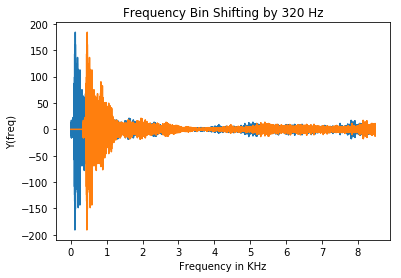

In [13]:
original_filepath = "../../data/dev-clean/1272/135031/1272-135031-0011.wav"
pitch_shift_file = "../../outputs/ps_output.wav"
freq_shift_file = "../../outputs/fs_output.wav"
pshift_fshift_file = "../../outputs/ps_fs_output.wav"

y, sr = librosa.load(original_filepath)

print("Original File:")
IPython.display.Audio(data=y, rate=sr)

print("After pitch shift File:")
y_shift = librosa.effects.pitch_shift(y, sr, 10, bins_per_octave=24)
IPython.display.Audio(data=y_shift, rate=sr)
librosa.output.write_wav(pitch_shift_file, y_shift, sr)

print("After Frequency shift:")
modify1(original_filepath,freq_shift_file)
IPython.display.Audio(freq_shift_file)


# print("After Pitch Shift and Frequency Shift")
# modify1(pitch_shift_file, pshift_fshift_file)
# IPython.display.Audio(pshift_fshift_file)


Original File:


Target Voice File:


../../data/dev-clean/1462/170142/1462-170142-0040.wav
After Chroma shift:
../../data/dev-clean/1272/135031/1272-135031-0011.wav


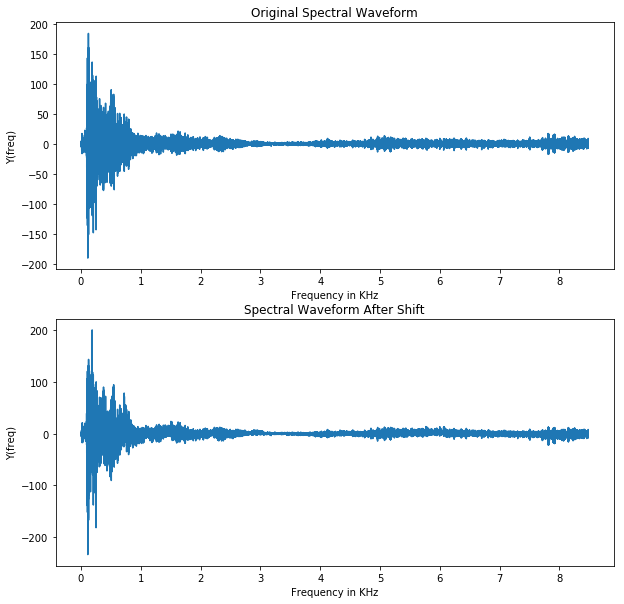

In [14]:
original_filepath = "../../data/dev-clean/" + p1.iloc[0]['pid']+"/"+p1.iloc[0]['chname']+"/"+p1.iloc[100]['fname']
targetvoice = "../../data/dev-clean/" + p2.iloc[0]['pid']+"/"+p2.iloc[0]['chname']+"/"+p2.iloc[100]['fname']
chroma_shift_file = "../../outputs/cs_output.wav"
# chroma_shift_file = "../../outputs/transformed_voice_demo.wav"

def modify_spectrum_chroma(spectrum, mean, var, tmean, tvar):
    
    chroma = [0] * 12
    
    for index in range(0, len(spectrum)):
        # Assign a frequency value to each bin
        f = index * (spectrum.sampleRate / 2.0) / len(spectrum)
        # Convert frequency to pitch to pitch class
        if f != 0:
            pitch = Pitch.frequencyToMidi(f)
        else:
            pitch = 0
        pitchClass = pitch % 12
        chroma[pitchClass] = chroma[pitchClass] + abs(spectrum[index])
    
    # Normalize the chroma vector
    norm = sum(chroma)
    chroma = [c / norm for c in chroma]
    
    for index in range(0, len(spectrum)):
        # Assign a frequency value to each bin
        f = index * (spectrum.sampleRate / 2.0) / len(spectrum)
        # Convert frequency to pitch to pitch class
        if f != 0:
            pitch = Pitch.frequencyToMidi(f)
        else:
            pitch = 0
        pitchClass = pitch % 12
        wt = abs(spectrum[index]) / chroma[pitchClass]
        spectrum[index] = (spectrum[index] - wt*mean[pitchClass])
        spectrum[index] = (spectrum[index] + wt*tmean[pitchClass])

def modify2(filepath, outputpath):
    print(filepath)
    adata = AudioFile.open(filepath)
    segments = adata.frames(2000000)
    spectra = [segment.spectrum() for segment in segments]
    
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,10))
    
    plt.subplot(2, 1, 1)
    plt.plot(spectra[0])
    plt.title("Original Spectral Waveform")
    plt.xlabel("Frequency in KHz")
    plt.xticks([0,3000,6000,9000,12000,15000,18000,21000,24000],[0,1,2,3,4,5,6,7,8])
    plt.ylabel("Y(freq)")
    for spectrum in spectra:
        modify_spectrum_chroma(spectrum, mean, var, tmean, tvar)
    plt.subplot(2, 1, 2)
    plt.plot(spectra[0])
    plt.title("Spectral Waveform After Shift")
    plt.xlabel("Frequency in KHz")
    plt.xticks([0,3000,6000,9000,12000,15000,18000,21000,24000],[0,1,2,3,4,5,6,7,8])
    plt.ylabel("Y(freq)")
    
    fdata = np.array([item for spectrum in spectra for item in Transforms.ifft(spectrum)])
    scaled = np.int16(fdata * 32767.0)
    scipy.io.wavfile.write(outputpath, spectra[0].sampleRate, scaled)


y, sr = librosa.load(original_filepath)
print("Original File:")
IPython.display.Audio(data=y, rate=sr)

print("Target Voice File:")
IPython.display.Audio(targetvoice)
print targetvoice

print("After Chroma shift:")
modify2(original_filepath,chroma_shift_file)
IPython.display.Audio(chroma_shift_file)